**Engy-4390** Nuclear Systems Design and Analysis, UMass Lowell, Chem. Eng. Nuclear Program Fall 2024; Prof. V. F. de Almeida

# Tritium Calculation for Molten Salt Reactor using FLiBe
$  
  \newcommand{\Amtrx}{\boldsymbol{\mathsf{A}}}
  \newcommand{\Bmtrx}{\boldsymbol{\mathsf{B}}}
  \newcommand{\Mmtrx}{\boldsymbol{\mathsf{M}}}
  \newcommand{\Imtrx}{\boldsymbol{\mathsf{I}}}
  \newcommand{\Pmtrx}{\boldsymbol{\mathsf{P}}}
  \newcommand{\Lmtrx}{\boldsymbol{\mathsf{L}}}
  \newcommand{\Umtrx}{\boldsymbol{\mathsf{U}}}
  \newcommand{\Smtrx}{\boldsymbol{\mathsf{S}}}
  \newcommand{\xvec}{\boldsymbol{\mathsf{x}}}
  \newcommand{\uvar}{\boldsymbol{u}}
  \newcommand{\fvar}{\boldsymbol{f}}
  \newcommand{\avec}{\boldsymbol{\mathsf{a}}}
  \newcommand{\bvec}{\boldsymbol{\mathsf{b}}}
  \newcommand{\cvec}{\boldsymbol{\mathsf{c}}}
  \newcommand{\rvec}{\boldsymbol{\mathsf{r}}}
  \newcommand{\mvec}{\boldsymbol{\mathsf{m}}}
  \newcommand{\gvec}{\boldsymbol{\mathsf{g}}}
  \newcommand{\zerovec}{\boldsymbol{\mathsf{0}}}
  \newcommand{\norm}[1]{\bigl\lVert{#1}\bigr\rVert}
  \newcommand{\transpose}[1]{{#1}^\top}
  \DeclareMathOperator{\rank}{rank}
  \newcommand{\Power}{\mathcal{P}}
$

**Student(s):** James Frye  <br>
**Course:** Engy-4390 Nuclear Systems Design and Analysis  <br>
**Mentor:** Prof. Subash Sharma
UMass Lowell, Dept. of Chemical Engineering, Nuclear Energy Program 
<br>
**16Dec2024**

[[Readme File]](https://github.com/dpploy/engy-4390/blob/main/projects/2024/tritium/README.md)

# Table of Contents
[Introduction](#introduction)  
[Parameters](#parameters)  
[Problem Statement](#problem)  
[Objectives](#objectives)  
[Approach](#approach)  
- [Analytical Solution](#analytical)
- [MOOSE Kernels](#moose-kernels)  
- [Finite Element](#finite-element)  
- [Setup](#setup)  
- [Tests](#tests)  
  - [1D Advection-Diffusion](#advection)  

[Results and Analysis](#results-and-analysis) <br>
[Velocity Relation](#velocity) <br>
[Mass Removed](#mass) <br>
[Conclusions](#conclusions) <br>
[References](#references)  



## [Introduction](#intro)<a id="introduction"></a>
Recent technology advances are creating growing interest in nuclear reactors that require advance high temperature salt coolants like Molten Salt Reactor (MSR). In a MSR the fuel is dissolved in the coolant salt with operating temperature at a range of $700^{o}C$ and $1000^{o}C$. At this temperature range the liquid salt produces tritium that can diffuse through metallic heat exchangers and escape the reactor system. To avoid exceeding allowable tritium releases to the environment, tritium removal from the salt coolant and barriers is required. 

In a lithium-containing Molten Salt, the primary tritium-producing reactions as follow

$${^{6}_{3}}LiF + n → {^{4}_{2}}He + TF $$
$${^{7}_{3}}LiF + n → {^{4}_{2}}He + TF + n' $$
$${^{19}_{9}}F + n → {^{17}_{8}}O + T $$


For the simplicity of the calculation it is assumed that the tritium and the fluoride diassociate into their respective monoatomic states. In this condition the tritium does not need to react with the wall of the pipe to disassociate so it can diffuse through. 

Therefore, the purpose of this project is to understand the tritium transport phenomena and select the correct model which will be tested in MOOSE. MOOSE is a partial differential solver using Finite Element Method (FEM) developed by Idaho National Laboratory. There are already existing models available in literature that have been benchmarks such as Tritium Diffusion Evolution and Transport (TRIDENT) developed by Stempien et al (2015,2016) at MIT. 


Consider molten salt in the main hot leg with the fuel-salt, flowing at steady-state, with dissolved tritium at an initial concentration, $ C_{inlet}$. Furthermore, sources indicate that tritium will diffuse into the pipe wall and the diffusion is limited by the mass transfer relation. The mass transfer coefficient was estimated using a Sherwood expression as such: 

$$Sh_{T_2,Pipe}=0.015Re^{0.83}Sc^{0.42}$$


## [Parameters](#toc)<a id="parameters"></a>

C = Concentration (mol/m^3) <br>
q = Concentration Flux (mol/m^3/s) <br>
r = Radius (cm) <br>
D = Diameter (cm) <br>
z = Length in Z direction (m) <br>
temp = Temperature (Kelvin) <br>
pressure = Pressure (Pascal) <br>
S = Flux Through Wall {Source Term} (mol/m^3/s) <br>
$v$ = Flow velocity (cm/s) <br>
$K_t$ = Mass Transport Coefficient (m/s) <br>
$K_s$ = Tritium Solubility in Solid (mol K /(m^3 Pa)) <br>
$K_l$ = Tritium Solubility in Liquid (mol K /(m^3 Pa)) <br>
$D_s$ = Tritium Diffusivity in Solid (m^2/s) <br>
$\Phi$ = Solid Permeability (mol K/(m Pa)/s) <br>
$\frac {\Lambda} {1 + \Lambda}\\ $= Source Constant (Unitless) <br>

## [Problem Statement](#toc)<a id="problem"></a>

The General Form 1D Convection-Diffusion Equation is written as follows.
\begin{align*}
\frac {\partial u} {\partial t} \ + v\frac {\partial u} {\partial x} = D\frac {\partial ^2u} {\partial x^2} + S(u,x)
\end{align*}
The 1D Advection-Diffusion Equation in the z-direction can be written as below as modeled by Humrickhouse. <br>
\begin{align*}
\frac {\partial C} {\partial t} \ + \frac {\partial } {\partial z}(vC-D\frac {\partial C} {\partial z}) = S(C,z) \\
\end{align*}

Where the Advection Flux is: <br>
$ vC $ <br>
And the Diffusion Flux is: <br>
$ -D\frac {dC} {dz}  $ <br>

The system is an open system, where tritium has the ability to leave the pipe by diffusing through the pipe wall because of this the equation above needs a term to represent this flux (or sink) out of the system, through the pipe wall (S).
Assuming the problem has reached Steady State, the change in the time equals zero ($ \frac {dC} {dt}  = 0) $ the equation becomes:
\begin{align*}
\frac {d} {dz}(vC-D\frac {dC} {dz}) - S(C,z) = 0 \\
\end{align*}
Such that for all $ C: [(z_a, z_b);] ∈ \mathbb{R} → \mathbb{P} $. <br>

At Steady State the flux inside the liquid metal and the pipe wall are equal. The sink term can be represented as a ratio of the liquid flux and the solid flux where one dominates.
\begin{align*}
S = -K_T(C - C_w,_l) = -\frac {K_T} {\pi D_\text{i}} C \frac {\Lambda} {1 + \Lambda}\\
\end{align*}

Where $ \Lambda $ represents the ($ \frac {flux_{max,solid}} {flux_{max,liquid}} ) $: <br>
\begin{align*}
\Lambda = \frac {2 D_s K_s} {K_T K_l d_i \ln(r_\text{o}/r_\text{i})} 
\end{align*}

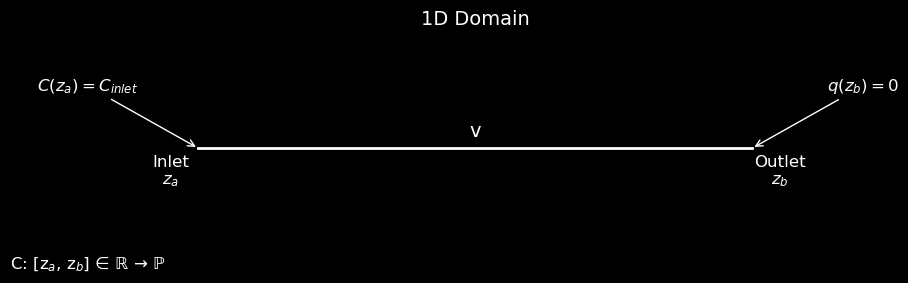

In [19]:
import os
import math
import matplotlib.pyplot as plt

z_start, z_end = 0, 10  
r_position = 0.5        
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot([z_start, z_end], [r_position, r_position], color='white', linewidth=2)
ax.text(z_start - 0.5,  r_position - 0.2, "Inlet\n$z_a$", fontsize=12, ha='center', va='center')
ax.text(z_end + 0.5, r_position -0.2, "Outlet\n$z_b$", fontsize=12, ha='center', va='center')
ax.text((z_start + z_end) / 2, r_position + 0.1, "v", fontsize=14, ha='center')
ax.annotate(
    "$C(z_a) = C_{inlet}$",
    xy=(z_start, r_position), xytext=(z_start - 2, r_position + 0.5),
    arrowprops=dict(facecolor='black', arrowstyle='->'),
    fontsize=12, ha='center'
)
ax.annotate(
    "$q(z_b) = 0$",
    xy=(z_end, r_position), xytext=(z_end + 2, r_position + 0.5),
    arrowprops=dict(facecolor='black', arrowstyle='->'),
    fontsize=12, ha='center'
)
ax.text(z_start - 2,  r_position - 1, r"C: [z$_a$, z$_b$] ∈ ℝ → ℙ", fontsize=12, ha='center', va='center')
ax.set_xlim(z_start - 2, z_end + 2)
ax.set_ylim(r_position - 1, r_position + 1)
ax.axis('off') 
ax.set_title("1D Domain", fontsize=14)

#plt.savefig('pics/domain.png') 
plt.style.use('dark_background')
plt.show()

In [21]:
'''Domain with Non-Overlapping Regions'''
def show_domain():
    import pyvista as pv
    pv.set_plot_theme('paraview')
    
    # Define parameters
    height = 15  # Height of the domain
    radius_inner = 0.5  # Radius of the inner region
    radius_outer = 0.75  # Radius of the outer region
    internal_region = pv.Cylinder(center=(0, 0, 0), direction=(1, 0, 0), height=height, radius=radius_inner)
    internal_region = internal_region.triangulate()
    outer_cylinder = pv.Cylinder(center=(0, 0, 0), direction=(1, 0, 0), height=height, radius=radius_outer)
    outer_cylinder = outer_cylinder.triangulate()
    external_region = outer_cylinder.boolean_difference(internal_region)
    plo = pv.Plotter(notebook=True, shape=(1, 1))
    plo.add_mesh(external_region, color='grey', opacity=0.75, label="External Region")
    plo.add_mesh(internal_region, color='red', opacity=1.0, label="Internal Region")
    plo.add_axes(xlabel='Z', ylabel='R', zlabel='')
    plo.set_viewup([0, 1, 0])

    # Show the plot
    plo.show(window_size=[800, 600])

show_domain()

Widget(value='<iframe src="http://localhost:51088/index.html?ui=P_0x2533346f9b0_2&reconnect=auto" class="pyvis…

## [Objectives](#toc)<a id="obj"></a>

1. Develop a model for diffusion of tritium through a pipe wall in 1D.
2. Calculate the analytical solution of the 1D model.
3. Implement the model into MOOSE and attain an understanding for MOOSE CFD software.
4. Calculate the relaxation length for the diffusion of tritium.
5. Understand the relation between velocity and the leaving of tritium from the system.

## [Approach](#toc)<a id="app"></a>

  1. Develop 1-D advection-diffusion problem statement.
  2. Get properties for RAFM pipe and FLiBe molten salt.
  3. Compose analytical solution to verify MOOSE
  4. Implement the advection-diffusion problem into MOOSE.
  5. Get the relaxation length for the release of tritium in both the numerical and analytical methods and compare.
  6. Get the 1st and 2nd derivatives of the relation between relaxation length and velocity.
  7. Use specific values of velocity and get the total mass removed from system.

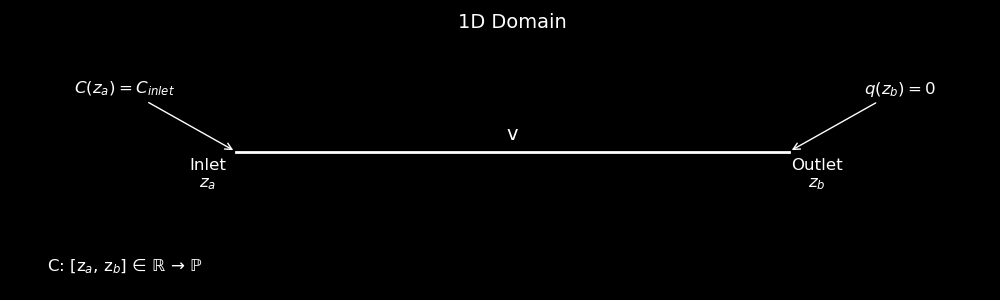

In [4]:
from IPython.display import Image

Image(filename='pics/domain.png')

### [Analytical Solution](#toc)<a id="analytical"></a>

The Analytical Solution can be represented as a 2nd Order Homogenous Ordinary Differential Equation, written as follows:
\begin{align*}
-DC'' + vC' + KC = 0
\end{align*}
The general form of the solution for a 2nd Order Homogenous Ordinary Differential Equation is:
\begin{align*}
C(z) = K_1e^{r_1} + K_2e^{r_2}
\end{align*}
Where $K_1$ and $K_2$ constants and $r_1$ and $r_2$ are roots of problem solved by doing:
\begin{align*}
-Dr^2 + vr + K = 0
\end{align*}
And getting $r_1$ and $r_2$ from the quadratic equation:
\begin{align*}
r_{1,2} = \frac{-v \pm \sqrt{v^2 - 4(-D)(K)}}{2(-D)} = \frac{v \mp \sqrt{v^2 + 4DK}}{2D}
\end{align*}
In this solution since $v$, D, and K are all positive non-zero coefficients will have one positive solution and one negative solution. <br>
$K_1$ and $K_2$ are solved using our boundary conditions, giving us two equations.
\begin{align*}
K_1 = \frac {C_\text{inlet}} {1 - \frac{r_1} {r_2}e^{(r_1-r_2) \times \infty}}
\end{align*}
and
\begin{align*}
K_2 = C_\text{inlet} - K_1
\end{align*}
Since $r_1 \neq r_2$, setting $r_1$ as the negative value root the solution is as follows:
\begin{align*}
K_1 = \frac {C_\text{inlet}} {1 - \frac{r_1} {r_2}e^{-\infty}} = \frac {C_\text{inlet}} {1} = C_\text{inlet}
\end{align*}
\begin{align*}
K_2 = C_\text{inlet} - K_1 = 0
\end{align*}
\begin{align*}
C(z) = C_\text{inlet}e^{r_1}
\end{align*}
Where $r_1$ is a negative value, leading to an exponential decay profile.

### [MOOSE Kernels](#toc)<a id="kernels"></a>

In order to input the weak form of the receding problem statment into MOOSE, it must be written in inner product notation:

\begin{align*} 
-( \nabla \varphi  , D \nabla C ) - < \varphi ,D \nabla C \cdot \vec{n} > + ( \varphi , \vec {v} \cdot \nabla C ) + (\varphi, S) =0. 
 \end{align*}

 
Where the MOOSE kernels used in this project to solve are as follows:


**Diffusion Kernel** : $(\nabla \varphi \ , \ -D \nabla C)$

 + [DiffusionTerm.h](./include/kernels/X.h) and [DiffusionTerm.C](./src/kernels/X.C)
 
 
**Advection Kernel** : $ (\vec {v} \cdot \nabla C)$

 + [AdvectionTerm.h](./include/kernels/X.h) and [AdvectionTerm.C](./src/kernels/X.C).

**Source Kernel** : $ (\varphi, K C \\) $

 + [SourceTerm.h](./include/kernels/X.h) and [SourceTerm.C](./src/kernels/X.C)
 
**Boundary Conditions** : $ <\varphi,D\nabla C\cdot\vec{n}> $ 
 
[**Inlet**] - MOOSE implemented DirichletBC

$ C(z_a) = a $

[**Outlet**] - MOOSE implemented NeumannBC 

$ q(z_b) = 0 $



### [Setup](#toc)<a id="setup"></a>

In [5]:
'''1-D Domain'''
#Explicit Parameters to Define Domain
z_left = 0 #m
z_right = 2500 #m #Represents Infinity
r_bottom = 0 #cm
r_top_inner = 0.5 #cm #Inner Radius of Pipe
r_top_outer = 0.75 #cm #Outer Radius of Pipe
diameter_inner = 2*(r_top_inner) #cm


'''Parameters'''
temp = 950 #Kelvin
vel = 0.5 #m/s

diff_coeff = .00000093*math.exp(-42154/((8.3144)*temp)) #m^2/s, high amount of resistance due to the bonding of Tritium as an ion
print('Diffusion Coefficient in fluid '+ '= ' + str(diff_coeff)+ ' m^2/s ')
s_source = 0
fluid_density= 2413.08 - 0.4884*(temp) #kg/m3
print('Density of fluid '+ '= ' + str(fluid_density)+ ' kg/m^3 ')
fluid_dynamic_viscosity= 0.000116*math.exp(3755/temp)  #Pa-s
print('Dynamic viscosity of fluid '+ '= ' + str(fluid_dynamic_viscosity)+ ' Pa-s ')
fluid_kinematic_viscosity = fluid_dynamic_viscosity/fluid_density
print('Kinematic viscosity of fluid '+ '= ' + str(fluid_kinematic_viscosity)+ ' Pa-s ')
fluid_solubility= 0.079*math.exp(-35000/((8.3144)*temp)) #Tritium Solubility in fluid ((mol K)/(m^3 Pa)), Using Henry's Law
print('Henrys law solubility of tritium in fluid '+ '= ' + str(fluid_solubility) + ' (mol K)/(m^3 Pa)')
solid_parameter= 0.0000000872*math.exp(-41800/((8.3144)*temp)) #Diffusivity*Solubility in Solid, Unique to RAFM Steel ((mol K)/(m^3 Pa))
print('Solubility of tritium in solid '+ '= ' + str(solid_parameter) + ' (mol K)/(m s Pa^.5)')

Re =  vel * (diameter_inner/100) / fluid_kinematic_viscosity #Reynolds Number 
print('Reynolds Number '+ '= ' + str(Re))

schmidt_number=(fluid_kinematic_viscosity/(diff_coeff))
print('The Schmidt Number of the fluid =  ' + str(schmidt_number))

Sherwood_exp1=0.015*pow(Re,0.83)*pow(schmidt_number,0.42)
print('The Sherwood Number using the expression in the introduction =   ' + str(Sherwood_exp1))

Mass_transfer_coeff=(Sherwood_exp1*diff_coeff)/(diameter_inner/100)
print('The Mass Transfer Coeffient =  ' + str(Mass_transfer_coeff)+'  m/s')

Peclet_Number= (r_top_inner/100)*vel/diff_coeff
print('The Peclet Number of the fluid =  ' + str(Peclet_Number))

Taylor_Dispersion = diff_coeff*(1 + pow(Peclet_Number,2)/48)
print('The Effective Taylor Dispersion of the fluid =  ' + str(Taylor_Dispersion)+ ' m^2/s ')

Diffusion Coefficient in fluid = 4.474271269723303e-09 m^2/s 
Density of fluid = 1949.1 kg/m^3 
Dynamic viscosity of fluid = 0.006040377385703471 Pa-s 
Kinematic viscosity of fluid = 3.099059763841502e-06 Pa-s 
Henrys law solubility of tritium in fluid = 0.0009401909518689916 (mol K)/(m^3 Pa)
Solubility of tritium in solid = 4.3875278948329706e-10 (mol K)/(m s Pa^.5)
Reynolds Number = 1613.3925709784148
The Schmidt Number of the fluid =  692.6401143382515
The Sherwood Number using the expression in the introduction =   107.52976874322978
The Mass Transfer Coeffient =  4.811173549278239e-05  m/s
The Peclet Number of the fluid =  558750.2074174873
The Effective Taylor Dispersion of the fluid =  29.101573307468403 m^2/s 


In [6]:
'''Data (boundary conditions)'''

u_inlet = 1.0 #mol/m^3
q_outlet = 0 #mol/m^3 #There is no more diffusion at the end of pipe, using arbitrarily large pipe to make sure this is actually true
velocity= vel #m/s

In [7]:
'''Calculating the Closure (Source) Term'''
import cmath

phi = solid_parameter
Lambda = 2*phi / (Mass_transfer_coeff * fluid_solubility * (diameter_inner/100) * math.log(r_top_outer/r_top_inner))
print('Lambda =  ' + str(Lambda))
source_constant = (Mass_transfer_coeff/(math.pi*diameter_inner/100)) * (Lambda/(Lambda + 1))
print('Source Constant (Unitless) =  ' + str(source_constant))

disc = vel**2 - (4*source_constant*-Taylor_Dispersion)
print('The Discriminant = ' +str(disc))
if disc < 0 :
    #Complex Analytical Solution Roots, if applicable
    real_part = -vel / (2 * -Taylor_Dispersion)
    imag_part = cmath.sqrt(-disc) / (2 * -Taylor_Dispersion)

    root1 = complex(real_part, imag_part)
    root2 = complex(real_part, -imag_part)
    imaginary_part = root1.imag
    #print(str(imaginary_part))
else:
    #Analytical Solution Roots
    root1 = (-vel + math.sqrt(1*pow(vel,2)-(4*source_constant*-Taylor_Dispersion)))/(2*-Taylor_Dispersion)
    root2 = (-vel - math.sqrt(1*pow(vel,2)-(4*source_constant*-Taylor_Dispersion)))/(2*-Taylor_Dispersion)
#Make sure the negative root is root 1
print('The Analytical Solution Roots Are ' + str(root1) + ' and ' + str(root2))

Lambda =  4.784420124267875
Source Constant (Unitless) =  0.0012666908414631257
The Discriminant = 0.397450785522952
The Analytical Solution Roots Are -0.002241064055895011 and 0.01942226572899094


In [8]:
#Analytical Solution Constants
if disc < 0 :
    constant1 = u_inlet
    constant2 = -1.5882*u_inlet
    print('The Analytical Solution, Exponential Coefficient is ' + str(real_part) + ' and the Trigonometric coefficient is ' +str(-imag_part))
    print('The Analytical Solution, The Cosine Constant is ' + str(constant1) + ' and the Sine Constant is ' + str(constant2))
    #At z = 0 C(z=0) = C_inlet so B*Cosine(i*z), B = C_inlet
    #Trig functions have no importance at final point
    #Sine can be any value
else:
    #Real Solution
    constant1 = u_inlet/(1-(root1/root2)*math.exp(z_right*(root1-root2)))
    constant2 = u_inlet-constant1
    print('The Analytical Solution Constants Are ' + str(constant1) + ' and ' + str(constant2))
    #Constant 1 approaches C_inlet
    #Constant 2 approaches 0

The Analytical Solution Constants Are 1.0 and 0.0


### [Tests](#toc)<a id="tests"></a>

#### [1D Advection-Diffusion](#toc)<a id="advection"></a>

In [9]:
!type hit-files\adv-dif1D.hit

# J. R. Frye
# Tritium Transport: 1D Advection-Diffusion
# UMass Lowell Nuclear Chemical Engineering, Added Flow through pipe wall
# Student: James Frye
# Original Student: Anthony Bowers
# Personal Instructor (PI): Dr. Shubash Sharma
# 9Dec24

#Parameters
#vel = 0.5 #m/s
#D = 29.101573307468403 #Taylor Dispersion Coefficient, m^2/s
#D = 4.474271269723303e-09 #Purely Diffusion Coefficient m^2/s
#K = -1.26669084146312575e-03 #Source Constant 1/s
 
[Mesh]
  type = GeneratedMesh
  dim = 1
  xmin = 0.0
  xmax = 25000.0
  nx = 100
  elem_type = EDGE3
[]

[Variables]
  [u]
    order = FIRST
    family = LAGRANGE
    initial_condition = 1.0
  []
[]

[Kernels]
  [advection-term]
    type = AdvectionTerm
    variable = u
    velocity = 0.5
  []

  [diffusion-term]
    type = DiffusionTerm
    variable = u
    D = 29.101573307468403
  []

  [source-term]
    type = SourceTerm
    variable = u
    K = -0.0012666908414631257
  []
[]

[BCs]
  [entry]
    type = DirichletBC
    variable = u
    boun

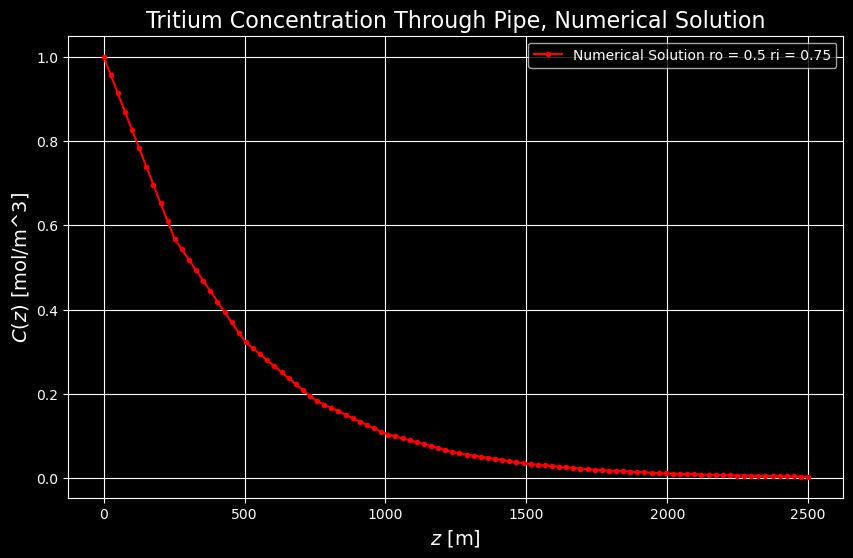

In [10]:
'''Plot function for FEM Solution'''

# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('dark_background')

# Read the CSV file
file_path = 'hit-files/output_u_0001.csv' 
df = pd.read_csv(file_path)


x_column = 'x' 
y_column = 'u'

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(df[x_column], df[y_column], marker='.', linestyle='-', color='r', label='Numerical Solution ro = 0.5 ri = 0.75')
plt.xlabel(r'$z$ [m]', fontsize=14)
plt.ylabel(r'$C(z)$ [mol/m^3]', fontsize=14)
plt.title('Tritium Concentration Through Pipe, Numerical Solution', fontsize=16)
plt.legend()
plt.grid(True)
plt.show()

## [Results and Analysis](#toc)<a id="ranalysis"></a>

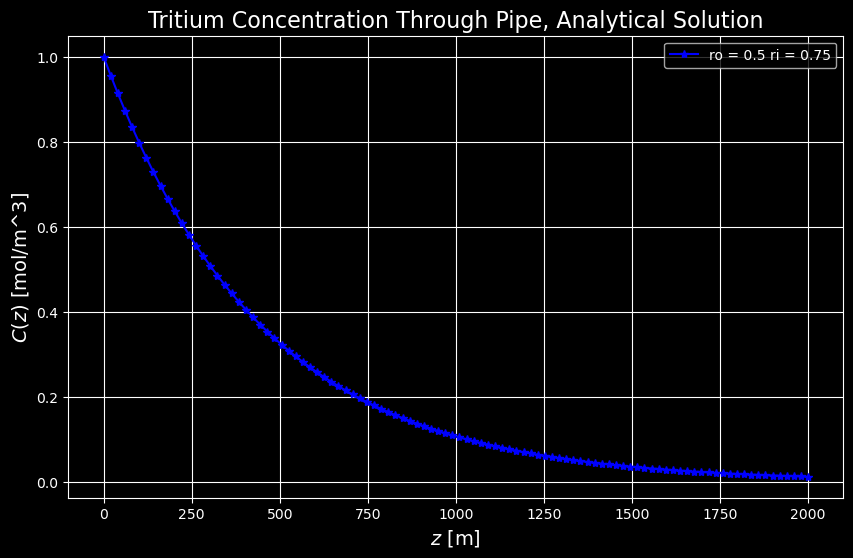

In [11]:
'''Plot the Analytical Solution'''
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('dark_background')

# Define exact solution
x = np.linspace(0, 2000, 100)
y = (constant1) * np.exp((root1) * x)

# Plot exact solution alone for testing
plt.figure(figsize=(10, 6))
plt.plot(x, y, 'b*-', label='ro = 0.5 ri = 0.75')
plt.xlabel(r'$z$ [m]', fontsize=14)
plt.ylabel(r'$C(z)$ [mol/m^3]', fontsize=14)
plt.title('Tritium Concentration Through Pipe, Analytical Solution', fontsize=16)
plt.legend()
plt.grid(True)
plt.show()

Fitted Exponential Decay Equation:
y = 1.021e+00 * exp(-2.235e-03 * z)


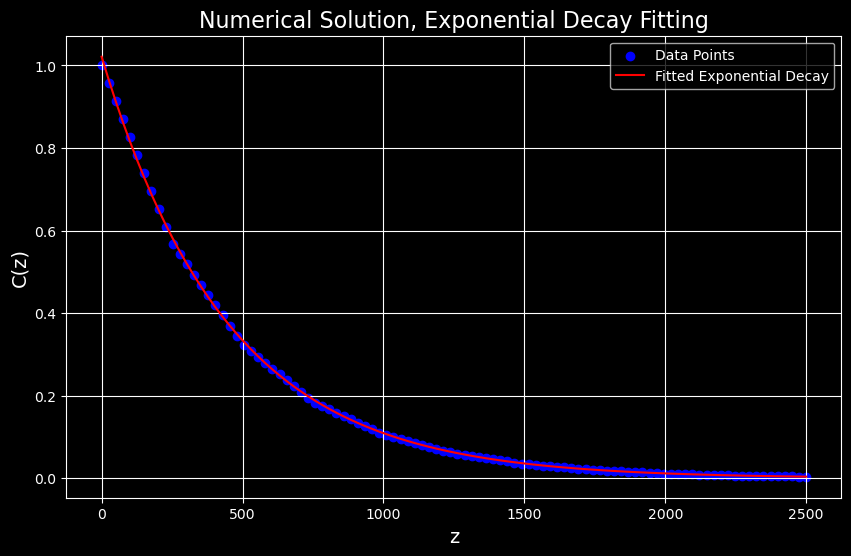

In [12]:
'''Get Fitted Function for FEM Solution'''
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Load the CSV file
file_path = 'hit-files/output_u_0001.csv'
df = pd.read_csv(file_path)


x = df['x'] 
y = df['u'] 

#Define fitted exponential function
def exp_decay(x, a, b):
    return a * np.exp(b * x)

# Fit the exponential decay curve
initial_guess = [1, root1]  # Initial guesses for a and b
params, covariance = curve_fit(exp_decay, x, y, p0=initial_guess)

a, b = params

fitted_curve = exp_decay(x, a, b)

# Display the fitted equation
print("Fitted Exponential Decay Equation:")
print(f"y = {a:.3e} * exp({b:.3e} * z)")

# Plot the data points and the fitted curve
plt.figure(figsize=(10, 6))
plt.scatter(x, y, color='blue', label='Data Points')  # Original data points
plt.plot(x, fitted_curve, color='red', label='Fitted Exponential Decay')  # Fitted curve
plt.xlabel('z', fontsize=14)
plt.ylabel('C(z)', fontsize=14)
plt.title('Numerical Solution, Exponential Decay Fitting', fontsize=16)
plt.legend()
plt.grid(True)
plt.show()

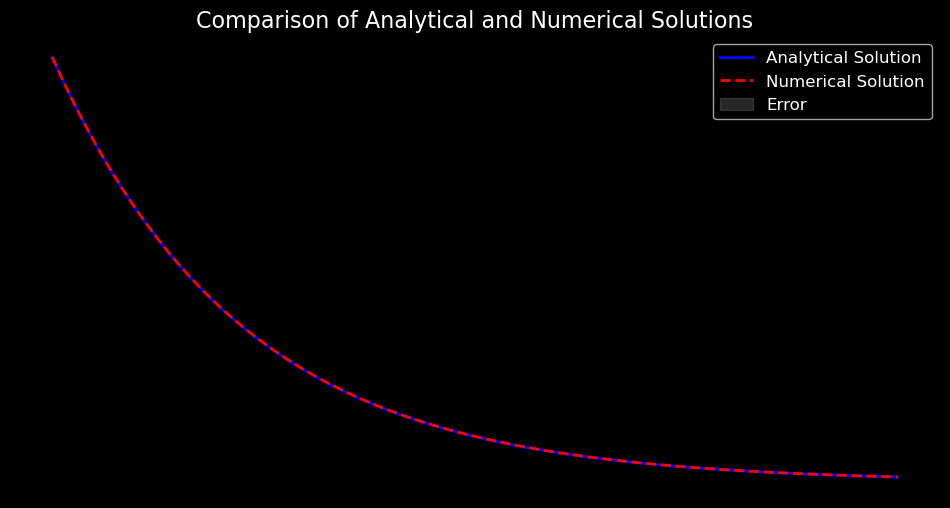

Maximum Error: 0.0009505942200155326
Mean Error: 0.0005397009178852438


In [23]:
'''FEM Solution vs Analytical Solution'''

import numpy as np
import matplotlib.pyplot as plt

# Define the solutions
def analytical_solution(x):
    return u_inlet * np.exp(root1 * x)

def numerical_solution(x):
    return u_inlet * np.exp(b * x)


x = np.linspace(0, 2000, 300)


y_analytical = analytical_solution(x)
y_numerical = numerical_solution(x)

# Calculate the error between the two solutions
error = np.abs(y_analytical - y_numerical)


plt.figure(figsize=(12, 6))
plt.plot(x, y_analytical, label='Analytical Solution', color='blue', linestyle='-', linewidth=2)
plt.plot(x, y_numerical, label='Numerical Solution', color='red', linestyle='--', linewidth=2)
plt.fill_between(x, y_analytical, y_numerical, color='gray', alpha=0.3, label='Error')
plt.xlabel('z', fontsize=14)
plt.ylabel('C(z)', fontsize=14)
plt.title('Comparison of Analytical and Numerical Solutions', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
#plt.axis('off')
#plt.savefig('pics/solution.png') 
#plt.style.use('dark_background')
plt.show()

# Display the error
print('Maximum Error:', np.max(error))
print('Mean Error:', np.mean(error))

In [14]:
'''Relaxation Lengths'''

b_analytical = root1
b_numerical = b

# Calculate relaxation lengths (68.3% Decay)
lambda_analytical = -1 / b_analytical
lambda_numerical = -1 / b_numerical

# Calculate 5x relaxation lengths (99% Decay)
lambda_analytical_5x = 5 * lambda_analytical
lambda_numerical_5x = 5 * lambda_numerical


print("Analytical Solution:")
print(f"  λ (68.3% Removal of Tritium): {lambda_analytical:.2f} m")
print(f"  5λ (99% Removal of Tritium): {lambda_analytical_5x:.2f} m")

print("\nNumerical Solution:")
print(f"  λ (68.3% Removal of Tritium): {lambda_numerical:.2f} m")
print(f"  5λ (99% Removal of Tritium): {lambda_numerical_5x:.2f} m")


Analytical Solution:
  λ (68.3% Removal of Tritium): 446.22 m
  5λ (99% Removal of Tritium): 2231.08 m

Numerical Solution:
  λ (68.3% Removal of Tritium): 447.37 m
  5λ (99% Removal of Tritium): 2236.86 m


## [Relaxation Length and Velocity Relation](#toc)<a id="velocity"></a>

Using the analytical solution the relaxation length can be calculated as a function of velocity or $Re$ which are interchangeable if the temperature and the pipe diameter remain constant:
\begin{align*}
\lambda = \frac {-1} {r_1} = \frac {2D(v)} {-v + \sqrt{v^2 + 4D(v)K(v)}} = \frac {2 (D_c + \frac{r^2} {48D_c} v^2)}{-v + \sqrt{v^2 + 4(D_c + \frac{r^2} {48D_c} v^2)(\frac {(\frac{\nu} {D_c})^{0.42} (0.015\frac{D_i} {\nu})^{0.83} (v)^{0.83}} {\pi D_i} \frac{\frac{2 \phi} {0.015D_c K_l \ln(\frac {D_o} {D_i})(\frac{\nu} {D_c})^{0.42} (\frac{D_i} {\nu})^{0.83} (v)^{0.83}} } {1 + \frac{2 \phi} {0.015D_c K_l \ln(\frac {D_o} {D_i})(\frac{\nu} {D_c})^{0.42} (\frac{D_i} {\nu})^{0.83} (v)^{0.83}}} )}}
\end{align*}
Which has two main profiles, depending on the size of $v$. <br> 
When $v$ is very small ($1 \gg v$) the profile is non-linear, simplifying to :
\begin{align*}
\lambda \approx \frac {2 (D_c + \frac{r^2} {48D_c} v^2)}{-v + \sqrt{4D_c + v^2 + 4(\frac{r^2} {48D_c})(\frac{0.03 \phi (\frac{\nu} {D_c})^{0.42} (\frac{D_i} {\nu})^{0.83}} {0.015\pi D_i D_c K_l \ln(\frac {D_o} {D_i})(\frac{\nu} {D_c})^{0.42} (\frac{D_i} {\nu})^{0.83}})v^{3.66}}}
\end{align*}
When $v$ is not very small ($1 \not\gg v$), the relation between velocity and the relaxation length is close to but not actually linear.
\begin{align*}
\lambda \approx \frac {2 (D_c + \frac{r^2} {48D_c} v^2)}{-v + \sqrt{4(D_c + \frac {0.015(\frac{\nu} {D_c})^{0.42} (\frac{D_i} {\nu})^{0.83} (v)^{0.83}} {\pi D_i}) + (1 + 4\frac{r^2} {48D_c})v^2}}
\end{align*}
The derivative ($\frac {\partial \lambda} {\partial v}$) was solved numerically due to the complexity of the function, obeying expected behavior, where the rate of change is infinite at $v = 0$, and trends towards a pseudo-asymptote based on the slope of the false linear portion of the graph. The derivative had two regions, at a low $v$ the profile obeyed a power law of velocity ($a v^{n}$). For the power law the exponent was equal to -0.83, or whatever the relation is for the Sherwood number which in our case was $Sh_{T_2,Pipe}=0.015Re(v)^{0.83}Sc^{0.42}$. The rest of the profile was a decay approaching an asymptote. <br> 

The curvature ($\frac {\partial^2 \lambda} {\partial v^2}$) was solved also solved numerically, obeying expected behavior, where the curvature is infinite and negative at $v = 0$, and trends towards zero. The curvature followed a power law at a sufficiently low $v$, which closely align to the derivative of the power law found for $\frac {\partial \lambda} {\partial v}$. Since $n = -0.83$ the graph was fully negative and approached zero showing at all points the rate of change was slowing down.
\begin{align*}
\frac {\partial^2 \lambda} {\partial v^2} \approx na v^{(n-1)}
\end{align*}

Below all graphs are as functions of $Re$. <br>

The Reynolds number where Xi equals the y-intercept is 436.99, correlating to a velocity of 0.135 m/s


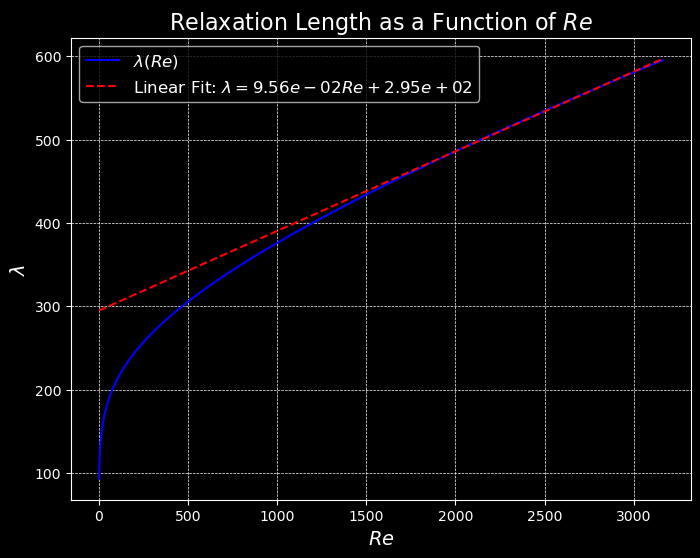

In [15]:
'''Graph the relation of Reynolds number and Tritium Permeation'''
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy.optimize import curve_fit

# Define lambda as a function of Reynolds number
def compute_lambda(Re):
    ln_ro_ri = np.log(r_top_outer / r_top_inner)
    Sc_term = (fluid_kinematic_viscosity / diff_coeff) ** 0.42  # Schmidt number portion
    Sh = 0.015 * Re ** 0.83 * Sc_term  # Sherwood number
    return 2 * phi / (Sh * diff_coeff * fluid_solubility * ln_ro_ri)

# Define K as a function of Reynolds number
def compute_K(Re):
    ln_ro_ri = np.log(r_top_outer / r_top_inner)
    Sc_term = (fluid_kinematic_viscosity / diff_coeff) ** 0.42  # Schmidt number portion
    Sh = 0.015 * Re ** 0.83 * Sc_term  # Sherwood number
    Mass_transfer_term = (Sh * diff_coeff) / (diameter_inner / 100)
    lambda_Re = compute_lambda(Re)
    return Mass_transfer_term / (np.pi * (diameter_inner / 100)) * lambda_Re / (1 + lambda_Re)

# Define D as a function of Reynolds number
def compute_D(Re):
    v = Re * (fluid_kinematic_viscosity / (diameter_inner / 100))  # Convert Re to velocity
    return diff_coeff + ((r_top_inner / 100) ** 2 / (48 * diff_coeff)) * v ** 2

# Define Xi as a function of Reynolds number
def compute_Xi(Re):
    v = Re * (fluid_kinematic_viscosity / (diameter_inner / 100))  # Convert Re to velocity
    D_Re = compute_D(Re)
    K_Re = compute_K(Re)
    discriminant = v ** 2 + 4 * D_Re * K_Re
    return 2 * D_Re / (-v + np.sqrt(discriminant))

# Generate Reynolds number values and compute Xi
Re_values = np.logspace(0, 3.5, 1000)  # Reynolds numbers from 10^1 to 10^6
Xi_values = [compute_Xi(Re) for Re in Re_values]

# Ensure Re_values and Xi_values are numpy arrays
Re_values = np.array(Re_values)
Xi_values = np.array(Xi_values)

# Define the region of interest for the linear fit
linear_region_mask = (Re_values > 1.75e3) & (Re_values < 3.5e3)  # Adjust range for the linear region
Re_linear_region = Re_values[linear_region_mask]
Xi_linear_region = Xi_values[linear_region_mask]

# Define the linear fit function
def linear_fit(Re, a, b):
    return a * Re + b

# Perform the linear fit
popt, _ = curve_fit(linear_fit, Re_linear_region, Xi_linear_region)
a_fit, b_fit = popt

# Generate the fitted values for plotting
Xi_linear_fit = linear_fit(Re_values, a_fit, b_fit)

# Function to find the root (where Xi = b_fit)
def find_re_exact(Re):
    return compute_Xi(Re) - b_fit

# Initial guess for the solver
initial_guess = 300
Re_exact = fsolve(find_re_exact, initial_guess)[0]

# Print the result
print(f"The Reynolds number where Xi equals the y-intercept is {Re_exact:.2f}, correlating to a velocity of {Re_exact * (fluid_kinematic_viscosity/(diameter_inner/100)):.3f} m/s")

# Plot the Xi values relative to Re, with the linear fit
plt.figure(figsize=(8, 6))
plt.plot(Re_values, Xi_values, label=r'$\lambda(Re)$', color='blue')
plt.plot(Re_values, Xi_linear_fit, label=f"Linear Fit: $\\lambda = {a_fit:.2e}Re + {b_fit:.2e}$", linestyle="--", color="red")
plt.xlabel(r'$Re$', fontsize=14)
plt.ylabel(r'$\lambda$', fontsize=14)
plt.title(r'Relaxation Length as a Function of $Re$', fontsize=16)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(fontsize=12)
plt.show()


The Power Law fitting coefficients: a = 9.557e-02 with n of -0.83


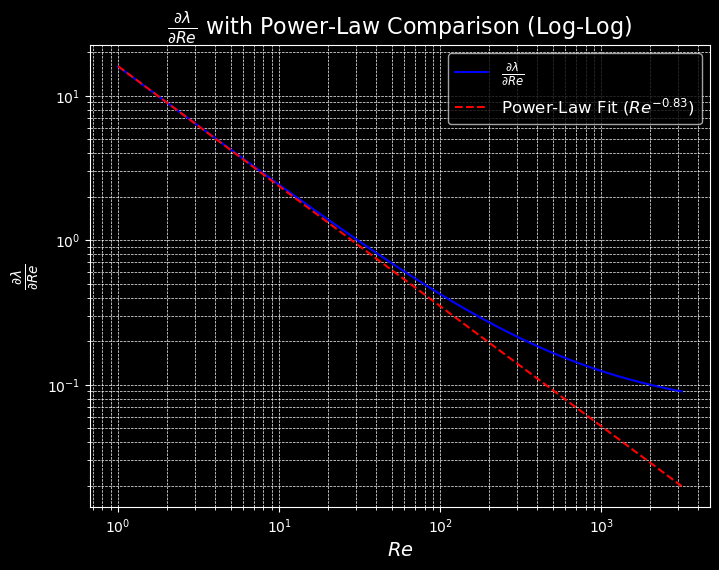

In [16]:
'''Get the Derivative of Relaxation Length in relation to Reynolds Number with Fixed n'''

# Compute the derivative of Xi with respect to Reynolds Number using numerical differentiation
Xi_derivative = np.gradient(Xi_values, Re_values)

# Define a power-law function
n = -0.83
def power_law_fixed(Re, a):
    return a * Re**n

np.seterr(over='ignore', invalid='ignore')  # Silence errors

# Fit the derivative data to the power-law model with fixed n
popt, pcov = curve_fit(power_law_fixed, Re_values, Xi_derivative, maxfev=10000)
a = popt[0]

# Print the fitted coefficient
print(f"The Power Law fitting coefficients: a = {a_fit:.3e} with n of {n:.2f}")

# Generate fitted values for comparison
Xi_derivative_fit = power_law_fixed(Re_values, a)

# Plot the derivative data and power-law fit
plt.figure(figsize=(8, 6))
plt.plot(Re_values, Xi_derivative, label=r"$\frac{\partial \lambda}{\partial Re}$", color='blue')
plt.plot(Re_values, Xi_derivative_fit, label=fr"Power-Law Fit ($Re^{{{n:.2f}}}$)", linestyle="--", color='red')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$Re$', fontsize=14)
plt.ylabel(r"$\frac{\partial\lambda}{\partial Re}$", fontsize=14)
plt.title(r'$\frac{\partial\lambda}{\partial Re}$ with Power-Law Comparison (Log-Log)', fontsize=16)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.legend(fontsize=12)
plt.show()

Reynolds number where curvature is 31.7% of the maximum: Re = 1.87
The Power Law fitting coefficients: a = 1.597e+01, n = -1.830


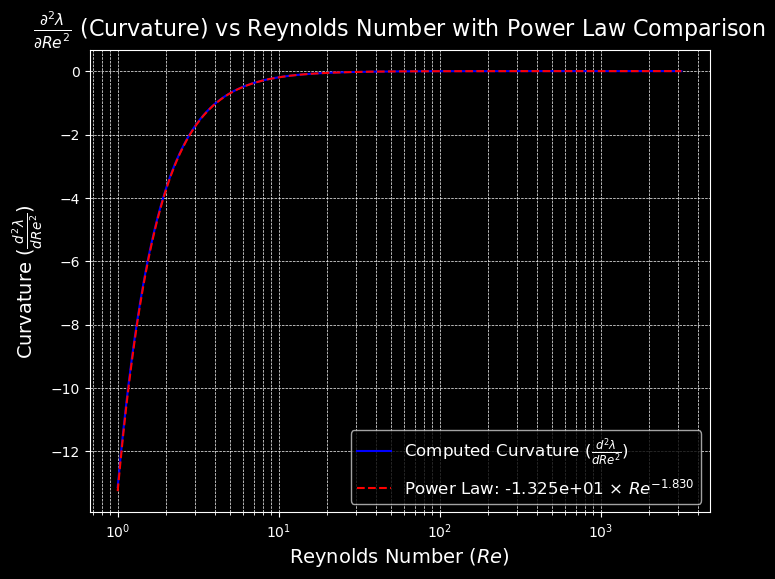

In [17]:
from scipy.optimize import root_scalar

# Define the curvature function based on Xi values (second derivative)
def compute_curvature(Re):
    h = 1e-2
    Xi_Re = compute_Xi(Re)
    Xi_Re_plus_h = compute_Xi(Re + h)
    Xi_Re_minus_h = compute_Xi(Re - h)
    second_derivative = (Xi_Re_plus_h - 2 * Xi_Re + Xi_Re_minus_h) / h**2
    return second_derivative


reference_Re = 400
reference_curvature = compute_curvature(reference_Re)
target_curvature = 0.317 * reference_curvature

def curvature(Re):
    return abs(compute_curvature(Re) - target_curvature)

Re_values = np.logspace(0, 3.5, 1000)
def compute_curvatures(Re_values):
    curvatures = []
    for Re in Re_values:
        try:
            curvature = compute_curvature(Re)
            curvatures.append(curvature)
        except:
            curvatures.append(np.nan)
    return np.array(curvatures)

curvatures = compute_curvatures(Re_values)
# Determine the maximum curvature using absolute values
max_curvature = np.nanmax(np.abs(curvatures))

# Find the relaxation length value
target_curvature = 0.317 * max_curvature

def curvature_difference(Re):
    try:
        return np.abs(compute_curvature(Re)) - target_curvature
    except:
        return np.inf
result = root_scalar(curvature_difference, bracket=[1, 3500], method='brentq')

if result.converged:
    Re_for_curvature = result.root
    print(f"Reynolds number where curvature is 31.7% of the maximum: Re = {Re_for_curvature:.2f}")
else:
    print("Root-finding did not converge.")

def modified_power_law(Re, a, n):
    return a * n * Re**(n-1)
fitted_curvatures = modified_power_law(Re_values, a, n)

print(f"The Power Law fitting coefficients: a = {a:.3e}, n = {n-1:.3f}")

plt.figure(figsize=(8, 6))
plt.plot(Re_values, curvatures, label=r"Computed Curvature ($\frac{d^2\lambda}{dRe^2}$)", color="blue")
plt.plot(Re_values, fitted_curvatures, label=fr"Power Law: {a*n:.3e} × $Re^{{{n-1:.3f}}}$", linestyle="--", color="red")
plt.xscale('log')
plt.xlabel("Reynolds Number ($Re$)", fontsize=14)
plt.ylabel(r"Curvature ($\frac{d^2\lambda}{dRe^2}$)", fontsize=14)
plt.title(r"$\frac{\partial^2\lambda}{\partial Re^2}$ (Curvature) vs Reynolds Number with Power Law Comparison", fontsize=16)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.legend(fontsize=12)
plt.show()

## [Mass Removed](#toc)<a id="mass"></a>

Convection dominance is determined by the y-intercept of the relaxation length versus $Re$, correlating the relaxation length to the actual $Re$. In contrast, curvature focus is determined by the relaxation of curvature, approximately $\sim31.7\%$, beginning at $Re = 1$, since at $Re = 0$, the curvature is infinite.

The mass removed ($M_\text{removed}$) was calculated using two methods:

1. **Source Term Method**: This approach represents all the mass leaving the system before the end:
\begin{align*}
M_\text{removed} = \frac {K_T} {\pi D_\text{i}} \frac {\Lambda} {1 + \Lambda}\ C = \frac {Sh D_c} {4} \frac {\Lambda} {1 + \Lambda} \frac {C_\text{inlet}} {-r_1} (1 - e^{r_1z})
\end{align*}

2. **Volume Integration Method**: This approach accounts for the volume of the system and the solved concentration profile:
\begin{align*}
M_\text{removed} = \frac{v \pi D_\text{i}^2}{4} C_\text{inlet} (1 - e^{r_1 z})
\end{align*}

The two methods produced matching results, with minor differences which can likely be attributed to rounding errors when solving terms such as $Sh$. <br>
The profiles revealed that systems with higher velocities ($v$), which required longer pipes, also removed more total tritium from the system. At the end of the system, a point was reached where all tritium was removed, and the value no longer changed. However, the higher throughput of longer pipes, when normalized by the residence time $(z/v)$ was insignificant at the end of the pipe.

Sh_conv = 36.366057414844846, Sh_curv = 0.39390792612611714
r1_conv = -0.003390699737480206, r1_curv = -0.009649011002091023


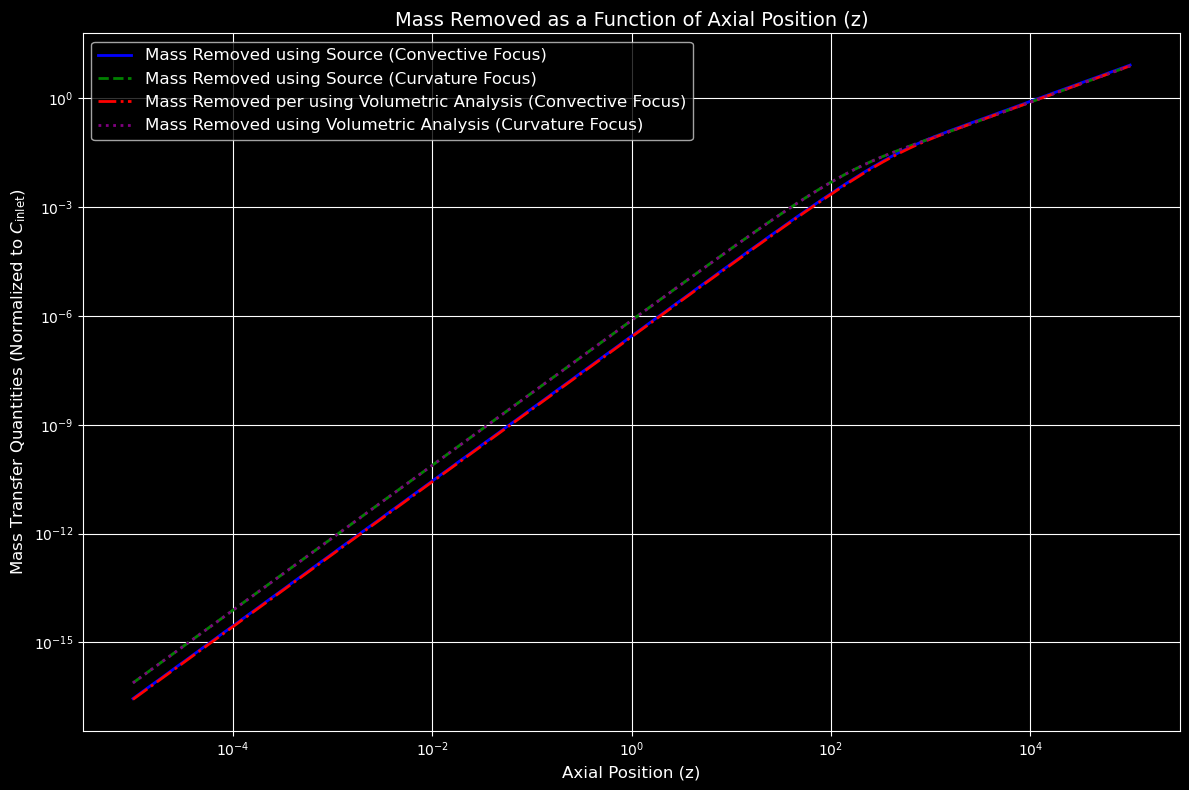

In [18]:
'''Getting mass removal from system'''
# Get Specific Velocities to test
v_convective = Re_exact * (fluid_kinematic_viscosity/(diameter_inner/100))
v_curvature = Re_for_curvature * (fluid_kinematic_viscosity/(diameter_inner/100))

# Solve for D at specific v
D_conv = diff_coeff + ((r_top_inner/100)**2 / (48 * diff_coeff)) * v_convective**2
D_curv = diff_coeff + ((r_top_inner/100)**2 / (48 * diff_coeff)) * v_curvature**2

# Get the K at specific v
Sh_conv = (v_convective * (diameter_inner/100) / fluid_kinematic_viscosity)**0.83 *  0.015*(fluid_kinematic_viscosity / diff_coeff)**0.42
lambda_conv = 2 * phi / (Sh_conv * diff_coeff * fluid_solubility * np.log(r_top_outer/r_top_inner))
K_conv = ((Sh_conv*diff_coeff)/(diameter_inner/100))/(np.pi * (diameter_inner/100)) * lambda_conv / (1 + lambda_conv)

Sh_curv = (v_curvature * (diameter_inner/100) / fluid_kinematic_viscosity)**0.83 *  0.015*(fluid_kinematic_viscosity / diff_coeff)**0.42
lambda_curv = 2 * phi / (Sh_curv * diff_coeff * fluid_solubility * np.log(r_top_outer/r_top_inner))
K_curv = ((Sh_curv*diff_coeff)/(diameter_inner/100))/(np.pi * (diameter_inner/100)) * lambda_curv / (1 + lambda_curv)

# Solve for the root for specific v
r1_conv = (v_convective - np.sqrt(v_convective**2 + 4*D_conv*K_conv))/(2*D_conv)
r1_curv = (v_curvature - np.sqrt(v_curvature**2 + 4*D_curv*K_curv))/(2*D_curv)

print(f"Sh_conv = {Sh_conv}, Sh_curv = {Sh_curv}")
print(f"r1_conv = {r1_conv}, r1_curv = {r1_curv}")

# Get the total mass removed
z = np.logspace(-5, 5, 1000)

# Cumulative mass removed
mass_removed_conv = (Sh_conv * diff_coeff) / 4 * lambda_conv / (1 + lambda_conv) * u_inlet / -r1_conv * (1 - np.exp(r1_conv * z)) /(v_convective/z)
mass_removed_curv = (Sh_curv * diff_coeff) / 4 * lambda_curv / (1 + lambda_curv) * u_inlet / -r1_curv * (1 - np.exp(r1_curv * z)) /(v_curvature/z)
# Corrected mass flow rate
mass_flow_rate_conv = u_inlet * (1 - np.exp(r1_conv * z)) * v_convective * (np.pi/4*(diameter_inner/100)**2) /(v_convective/z)
mass_flow_rate_curv = u_inlet * (1 - np.exp(r1_curv * z)) * v_curvature * (np.pi/4*(diameter_inner/100)**2) /(v_curvature/z)

# Plotting the results
plt.figure(figsize=(12, 8))
plt.plot(z, mass_removed_conv, label='Mass Removed using Source (Convective Focus)', linestyle='-', linewidth=2, color='blue')
plt.plot(z, mass_removed_curv, label='Mass Removed using Source (Curvature Focus)', linestyle='--', linewidth=2, color='green')
plt.plot(z, mass_flow_rate_conv, label='Mass Removed per using Volumetric Analysis (Convective Focus)', linestyle='-.', linewidth=2, color='red')
plt.plot(z, mass_flow_rate_curv, label='Mass Removed using Volumetric Analysis (Curvature Focus)', linestyle=':', linewidth=2, color='purple')
plt.title('Mass Removed as a Function of Axial Position (z)', fontsize=14)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Axial Position (z)', fontsize=12)
plt.ylabel(r'Mass Transfer Quantities (Normalized to $C_\text{inlet}$)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

## [Conclusions](#toc)<a id="conclusions"></a>

Using the Humrickhouse model for Tritium permeation through the pipe wall and applying it as a source term for a one-dimensional convection-diffusion equation with laminar Taylor dispersion, the concentration profile exhibited an exponential decay. Due to this profile, the length required to remove tritium from the system was not dependent on the initial concentration being fed into the system. This statement holds true only when the tritium concentration is low enough for Henry’s Law to apply, as the partial pressure of tritium influences the liquid solubility for the source term. 

The relaxation length of tritium in the system, at a velocity of 0.5 m/s (Re $\approx$ 1600), which is below the well-planned operating speeds for molten salt reactors, was approximately 450 m. This value agreed with both the analytical and numerical models, but it exceeds the bounds for a viable size of a permeator for tritium extraction. Moreover, the length increases further with rising $Re$, suggesting that this trend continues into turbulent flow. 

The relaxation length grew with increased dispersive forces and decreased with a higher permeation rate through the pipe wall. Velocity had a unique relationship with the relaxation length because every parameter in the advection-diffusion equation is itself a function of velocity (or $Re$). The relaxation length exhibited two distinct regions: one where the system was source-dominated at low velocity and another where it was convection-diffusion-dominated at high velocity. 

The rate of change of the relaxation length also showed two regions: a linearly decreasing region corresponding to the exponential of $Re$ in the Sherwood Number, and a region approaching an asymptote. The amount of tritium removed from the system varied with $Re$, with larger pipe lengths required for tritium removal also correlating to greater amounts of tritium being extracted from the system. However, the total throughput of tritium through the entire pipe, when accounting for the amount of time spent in the pipe, showed that longer pipes with a higher $Re$ were no different from shorter pipes with a lower $Re$. This leaves the choice ultimately up to design conditions. If the goal is to extract all the tritium from the system, longer pipes may be more suitable; however, if the goal is to extract a certain fraction of tritium, shorter pipes with a lower $Re$ are more efficient.

## [References](#toc)<a id="refs"></a>

- [1] V. F. de Almeida, [*Engy-5330: Computational Transport Phenomena*](https://github.com/dpploy/engy-5330),  University of Massachusetts Lowell, Dept. of Chemical Engineering (Nuclear Energy Program).
- [2] V. F. de Almeida, [*Engy-4390: Nuclear System Design and Analysis*](https://github.com/dpploy/engy-4390),  University of Massachusetts Lowell, Dept. of Chemical Engineering (Nuclear Energy Program).
- [3] Multiphysics Object-Oriented Simulation Environment [(MOOSE)](https://mooseframework.org)
- [4] P. Humrickhouse, P. Calderoni, and B. Merrill “Implementation of Tritium Permeation Models in the CFD Code Fluent”
- [5] P. Humrickhouse, B. Merrill “Vacuum Permeator Analysis for Extraction of Tritium from DCLL Blankets” <br>
- [6] Stempien D. John, “Tritium Transport, Corrosion, and Fuel Performance Modeling in Fluoride Salt-Cooled High-Temperature Reactor (FHR)”. Massachusetts Institute of Technology. PDF. June 2017
- [7] R. Serrano-Lópeza, J. Fraderaa, S. Cuesta-Lópeza. “Molten salts database for energy applications”. PDF. September 2014.
- [8] M. Sugisaki, H. Furuya, K. Ono, K. Idemitsu. “Tritium solubility in SUS-316 stainless steel”. Journal of Nuclear Materials. PDF. February 1984
- [9] B. Garcinuño, D. Rapisarda, I. Fernández-Berceruelo, D. Jiménez-Rey, J. Sanz, C. Moreno, I. Palermo, Á. Ibarra. “Design and fabrication of a Permeator Against Vacuum prototype for small scale testing at Lead-Lithium facility”. Fusion Engineering and Design. PDF. November 2017